# Self-Driving Car Engineer Nanodegree Program


## Project 1: **Finding Lane Lines on the Road** 
***
In this project, we will use basic computer vision tecqniques to identify and label lanes over images and video.
We will make use of Canny transform, grayscaling, Hough lines, gaussian blur and polygonal masking.
This is the first project of the Self-Driving Car Engineer Nanodegree Program.


---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [85]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Visualizing the test images

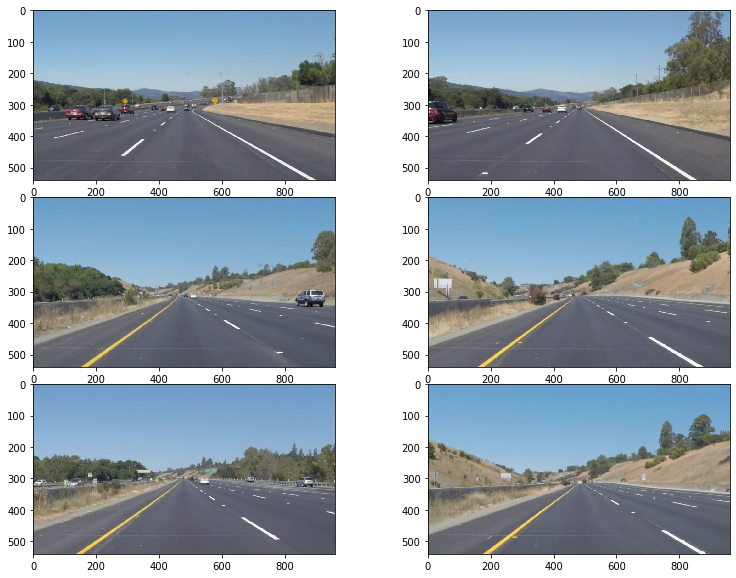

In [86]:
#using the function subplots to visualize all the images in the folder
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(14,10))
fig.subplots_adjust(hspace = .1, wspace=.02)
axs = axs.ravel()

i=0
for img in test_images:
    img = mpimg.imread(img)
    axs[i].imshow(img)
    i+=1

## Helper Functions

Below are the helper functions that will be utilized for the detection.

In [87]:
import math

#This will return an image with only one color channel
def grayscale(img): 
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#This will apply the Canny transform to see only edges    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#This is used to smooth the image by blurring, and make the canny transform more stable
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#This is for defining a polygonal area to mask the edges
def region_of_interest(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, vertices, ignore_mask_color) <-- bugfix, fillPoly function needs an array for vertices
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32), ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#This function is used later in the code, to extrapolate/interpolate the lines, especially in the case of segmented ones

#The below code is not my own. It is copied from a fellow student (https://github.com/peps0791/Udacity-SDCNDP-Lane-Finding), which I deeply thank for.
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    #LINE PARAMETERS
    color = [255, 255, 0]
    thickness = 10
    SLOPE_THRESHOLD = 0.3
    Y_MIN_ADJUST = 15
    
    #create empty arrays
    pos_slopes = []
    neg_slopes = []
    
    pos_intercepts = []
    neg_intercepts = []
    
    #due to python processing makes y axis in reverse direction
    y_max = img.shape[0]
    y_min = img.shape[0]
    
    #process for each output of the hough line transform
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #calculate slope for the line
            slope = (y2-y1)/(x2-x1)
            intercept = y2 - (slope*x2)
            
            #for negative slope
            if slope < 0.0 and slope > -math.inf and abs(slope) > SLOPE_THRESHOLD:
                neg_slopes.append(slope)
                neg_intercepts.append(intercept)
                
            #for positive slope
            elif slope > 0.0 and slope < math.inf and abs(slope) > SLOPE_THRESHOLD:
                pos_slopes.append(slope)
                pos_intercepts.append(intercept)
            
            y_min = min(y_min, y1, y2)
            y_min+=Y_MIN_ADJUST
    
    #get averages for positive and negative slopes
    pos_slope_mean = np.mean(pos_slopes)
    neg_slope_mean = np.mean(neg_slopes)

    #get averages for potitive and negative intercepts
    pos_intercept_mean = np.mean(pos_intercepts)
    neg_intercept_mean = np.mean(neg_intercepts)
    
    #calculation of coordinates for lane for positive slopes
    if len(pos_slopes) > 0:
        x_max = int((y_max - pos_intercept_mean)/pos_slope_mean)
        x_min = int((y_min - pos_intercept_mean)/pos_slope_mean)
        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    #calculation of coordinates for lane for negative slopes
    if len(neg_slopes) > 0:
        x_max = int((y_max - neg_intercept_mean)/neg_slope_mean)
        x_min = int((y_min - neg_intercept_mean)/neg_slope_mean)
        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
            
            
#This apply Hough transformation to identify from Canny images the parts that appear linear
#This function also uses the above one at the end to extrapolate/interpolate the lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

#This is to blend 2 images, in specific the input one with the final lines
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

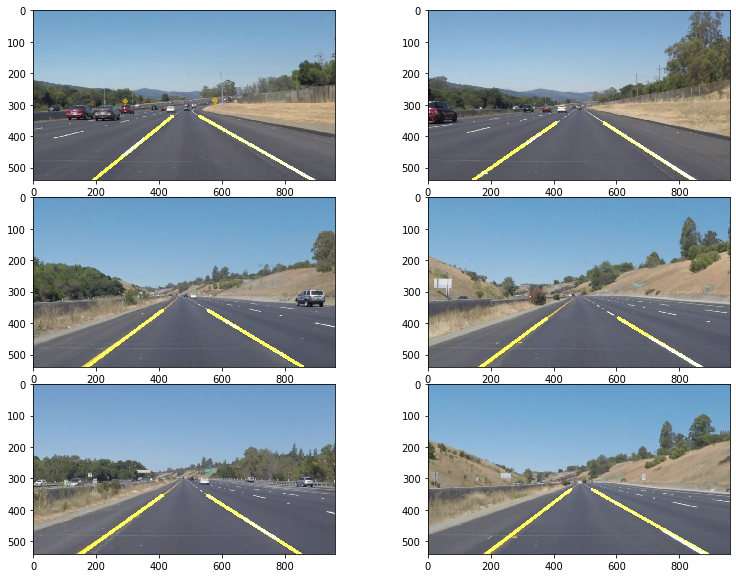

In [89]:
import os

#Read all files
files = os.listdir("test_images/")

#The below pipeline is taken from Udacity youtube video about Lane Project (https://youtu.be/hnXkCiM2RSg)

for file in files:
    if file[0:6] != "output":
        
        img = mpimg.imread("test_images/"+file)
        
        #first make them grayscale and blur them
        gray = grayscale (img)
        gray = gaussian_blur(gray,3)
        cv2.imwrite("for_markup/gray/output_"+file, gray)
        
        #create edges image
        edges = canny(gray, 50, 150)
        cv2.imwrite("for_markup/canny/output_"+file, edges)
        
        #define the polygonal mask based on horizon and image size, and apply the mask to the above canny image
        imshape = img.shape
        vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]])
        target = region_of_interest(edges,vertices)
        cv2.imwrite("for_markup/target/output_"+file, target)
        
        #create hough lines and blend them with the original image
        lines = hough_lines(target,1,np.pi/180,35,5,2)
        cv2.imwrite("for_markup/lines/output_"+file, lines)
        result = weighted_img(img,lines,α=0.8, β=1.)
        
        #due to plot function issue, need to split the colors and rearrange them into bgr
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        
        #write the images into a separate folder
        cv2.imwrite("test_images_output/output_"+file, result)
        
#now plot all 6 outputs
        
output_images = glob.glob('./test_images_output/*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(14,10))
fig.subplots_adjust(hspace = .1, wspace=.02)
axs = axs.ravel()

i=0
for img in output_images:
    img = mpimg.imread(img)
    axs[i].imshow(img)
    i+=1
 

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test video

In [49]:
imageio.plugins.ffmpeg.download()

NameError: name 'imageio' is not defined

Now that we were able to process images, we can use the same process to video too.

In [84]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [72]:
def process_image(image):

    #grayscale and blur
    gray = grayscale (image)
    gray = gaussian_blur(gray,3)
    
    #apply Canny transformation
    edges = canny(gray, 50, 150)
        
    #create polygonal mask and apply it to the images
    imshape = img.shape
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]])
    target = region_of_interest(edges,vertices)
        
    #create Hough lines and merge them to the original images
    lines = hough_lines(target,1,np.pi/180,35,5,2)
    result = weighted_img(image,lines,α=0.8, β=1.)

    return result

Let's try the one with the solid white lane on the right first ...

In [73]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 13.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [75]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 38.7 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

At this point, the function works but present many limitations. Please see the below video for how the function behaves on curved lines.

In [23]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 1min 21s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))